<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Предсказание-предыдущим-фактическим-значением-(base-line)" data-toc-modified-id="Предсказание-предыдущим-фактическим-значением-(base-line)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Предсказание предыдущим фактическим значением (base line)</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Гибридная-модель" data-toc-modified-id="Гибридная-модель-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Гибридная модель</a></span><ul class="toc-item"><li><span><a href="#Тренд" data-toc-modified-id="Тренд-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Остатки" data-toc-modified-id="Остатки-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Остатки</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Гибридная-модель" data-toc-modified-id="Гибридная-модель-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Гибридная модель</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm

from tqdm import tqdm

In [2]:
DATA_PATH = '/datasets/taxi.csv'
df = pd.read_csv(DATA_PATH)
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index()
df = df.resample('H').sum()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


***Вывод:*** пропусков нет, данные в цифровом виде, индекс в формате даты, грануляция данных соответствует заданию. Можно приступать к прогнозированию.

## Анализ

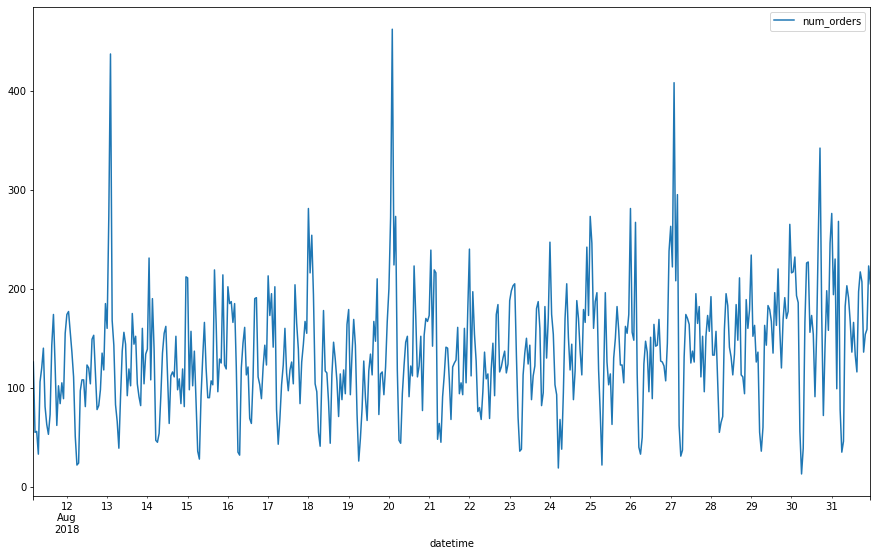

In [6]:
df[-500:].plot(figsize=(15,9))
None

Явно видны недельные пики (в районе 13, 20 и 27 августа), а также дневные пики.

In [7]:
decomposed = seasonal_decompose(df, period=24)

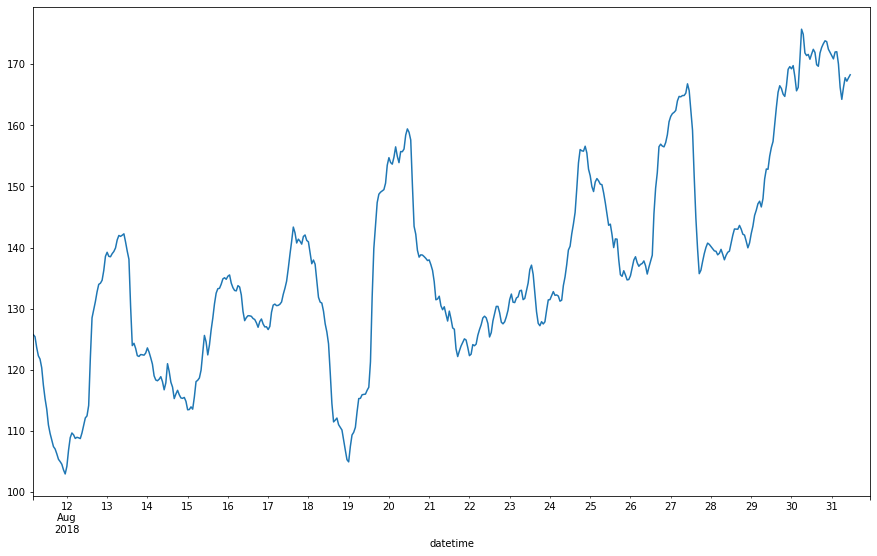

In [8]:
decomposed.trend[-500:].plot(figsize=(15,9)).plot()
None

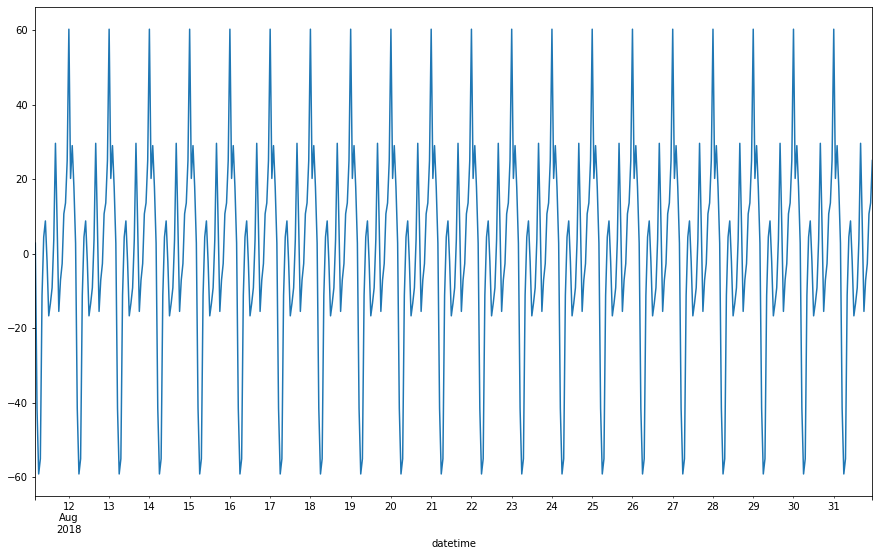

In [9]:
decomposed.seasonal[-500:].plot(figsize=(15,9))
None

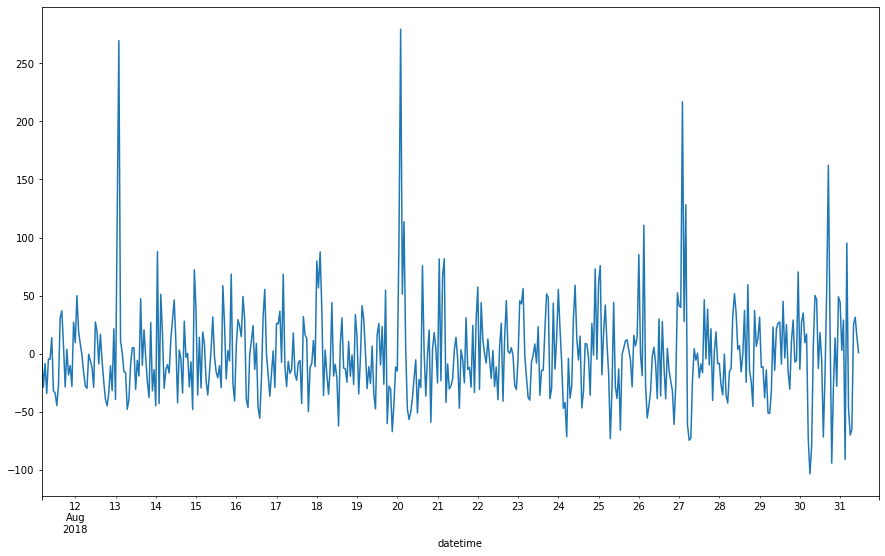

In [10]:
decomposed.resid[-500:].plot(figsize=(15,9))
None

***Вывод:*** на первом графике явно виден аддитивный тренд, сезонность - идеальный равномерный цикл, в остатках все еще видны недельные пики (в statsmodel не самый лучший алгоритм разделения временного ряда на составляющие).

## Обучение

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    #df['row_number'] = df.reset_index().index
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

def get_lag_scores(model, df):
    test = df[-len(df)//10:]
    train = df[:-len(test)]
    train = train.dropna()
    test = test.dropna()
    model.fit(train.drop(columns='num_orders'), train['num_orders'])
    preds_train = model.predict(train.drop(columns='num_orders'))
    preds_test = model.predict(test.drop(columns='num_orders'))
    rmse_train = mean_squared_error(train['num_orders'], preds_train, squared=False)
    rmse_test = mean_squared_error(test['num_orders'], preds_test, squared=False)
    return rmse_train, rmse_test

Разделим данные на обучающую и тестовую выборки в соответствии с критерием задания. 

In [12]:
X = make_features(df.copy(), 6, 6)
test = X[-len(X)//10:]
train = X[:-len(test)]
print('X', X.shape)
print('train', train.shape)
print('test', test.shape)

X (4416, 11)
train (3974, 11)
test (442, 11)


Сумма строк train и test соответствуют количеству строк исходного датасета

In [13]:
train = train.dropna()

### Предсказание предыдущим фактическим значением (base line)

Зададим base line примитивным алгоритмом. Если точность модели будет ниже, ее использование не имеет смысла.

In [14]:
dummy_rmse = mean_squared_error(test['num_orders'][1:], test['num_orders'].shift().dropna(), squared=False)
print('RMSE base line', dummy_rmse)

RMSE base line 58.91761802963282


### Линейная регрессия

In [15]:
%%time

lr = LinearRegression()
lr.fit(train.drop(columns='num_orders'), train['num_orders'])
lr_preds = lr.predict(test.drop(columns='num_orders'))
lr_rmse = mean_squared_error(test['num_orders'], lr_preds, squared=False)
print('RMSE линейной регрессии', round(lr_rmse, 2))

RMSE линейной регрессии 55.11
Wall time: 24 ms


Подберем оптимальные значения количества лагов и размера скользящего окна

In [16]:
df_result = pd.DataFrame(columns=['params', 'RMSE train', 'RMSE test'])

for max_lag in tqdm(range(1, 60)):
    for window in range(1, 60):
        df_wlags = make_features(df.copy(), max_lag, window)
        lr = LinearRegression()
        lr_rmse_train, lr_rmse_test = get_lag_scores(lr, df_wlags)
        df_result.loc[len(df_result)] = [f'{max_lag}, {window}', lr_rmse_train, lr_rmse_test]

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [04:19<00:00,  4.39s/it]


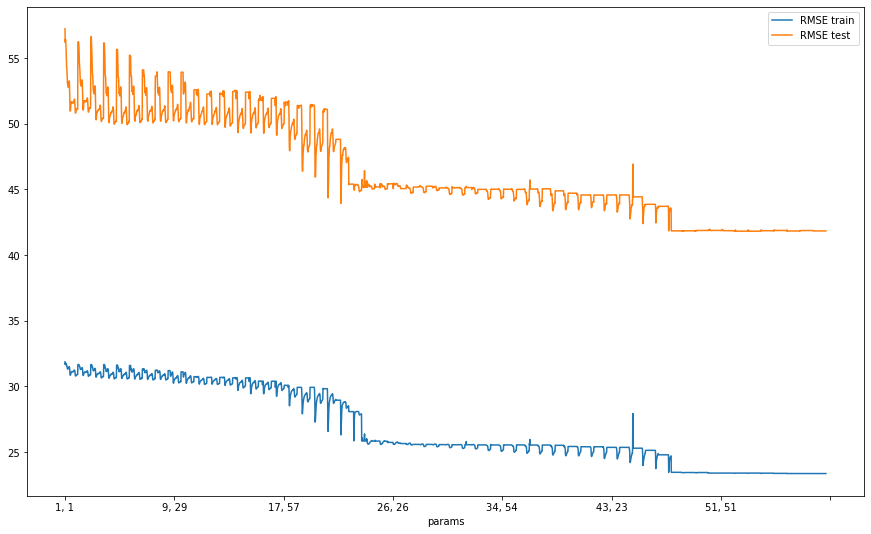

In [17]:
df_result.set_index('params').plot(figsize=(15,9))
None

In [18]:
df_result.sort_values('RMSE test').head(1)

,params,RMSE train,RMSE test
3072,"53, 5",23.387832,41.805456


Остановимся в районе первого резкого снижения ошибки на тесте. После этого модель будет усложняться, но значительного улучшения точности не происходит. При этом существует риск уйти в зону переобучения.

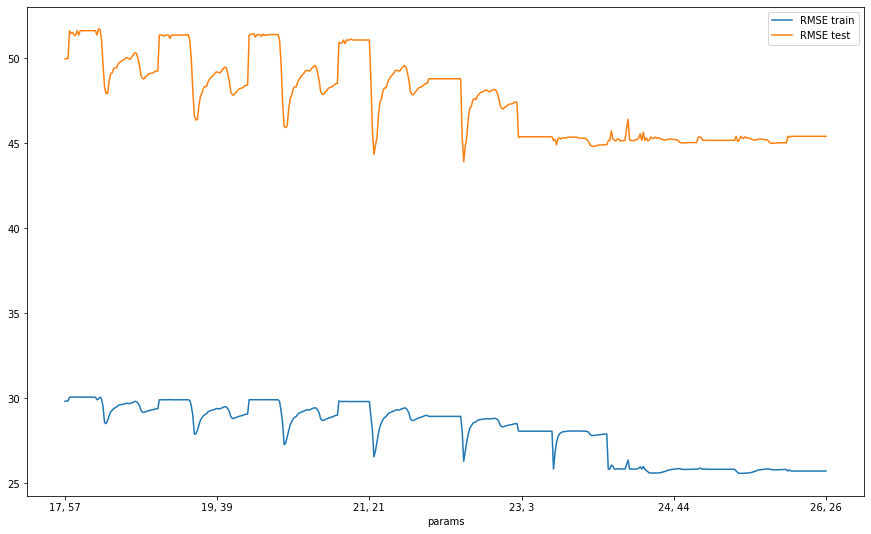

In [19]:
df_result.set_index('params').loc['17, 57':'26, 26',:].plot(figsize=(15,9))
None

In [20]:
print('Оптимальные параметры для модели линейной регрессии')
df_result.set_index('params').loc['17, 57':'26, 26',:].sort_values('RMSE test').head(1)

Оптимальные параметры для модели линейной регрессии


,RMSE train,RMSE test
params,,
"22, 24",26.300693,43.932301


### Градиентный бустинг

In [21]:
%%time

lgbm = lightgbm.LGBMRegressor()
lgbm.fit(train.drop(columns='num_orders'), train['num_orders'])
lgbm_preds = lgbm.predict(test.drop(columns='num_orders'))
lgbm_rmse = mean_squared_error(test['num_orders'], lgbm_preds, squared=False)
print('RMSE LightGBM', round(lgbm_rmse,2))

RMSE LightGBM 49.54
Wall time: 172 ms


In [22]:
df_result = pd.DataFrame(columns=['params', 'RMSE train', 'RMSE test'])

for max_lag in tqdm(range(1, 60)):
    for window in range(1, 60):
        df_wlags = make_features(df.copy(), max_lag, window)
        lgbm = lightgbm.LGBMRegressor()
        lgbm_rmse_train, lgbm_rmse_test = get_lag_scores(lgbm, df_wlags)
        df_result.loc[len(df_result)] = [f'{max_lag}, {window}', lgbm_rmse_train, lgbm_rmse_test]

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [13:26<00:00, 13.67s/it]


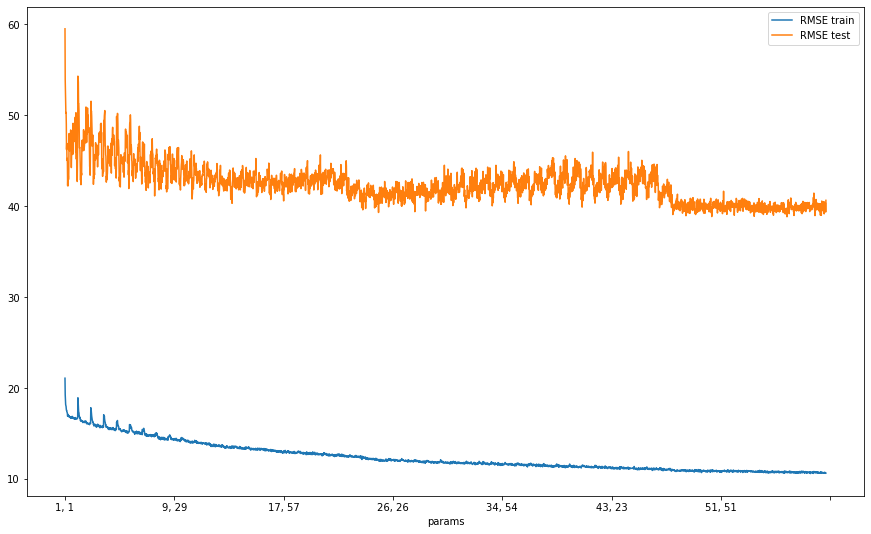

In [23]:
df_result.set_index('params').plot(figsize=(15,9))
None

In [24]:
df_result.sort_values('RMSE test').head(1)

,params,RMSE train,RMSE test
3302,"56, 58",10.748153,38.826871


In [25]:
print('Оптимальные параметры для модели градиентного бустинга')
df_result.set_index('params').loc['17, 57':'26, 26',:].sort_values('RMSE test').head(1)

Оптимальные параметры для модели градиентного бустинга


,RMSE train,RMSE test
params,,
"25, 19",12.068553,39.298137


***Вывод:*** для градиентного бустинга выберем параметры в том же диапазоне, что и у линейной регрессии - после первого резкого снижения ошибки на обучающей выборке. Значение ошибки ниже целевого уже для линейной регрессии. Для градиентного бустинга значение еще ниже. Задача выполнена, однако попробуем собственную модель. Возможно, она даст лучшую точность предсказаний. 

### Гибридная модель

В собственной модели разделим временной ряд на три составляющие: тренд, сезонность и остатки. Тренд будем предсказывать линейной регрессией, так как линейная модель лучше всего подходит для интерполяции. Сезонность будем предсказывать рядами Фурье. Остаки будем предсказывать градиентным бустингом (остатки должны быть стационарными, для стационарного ряда лучше всего подходят "деревянные" модели). На финальной стадии сложим предсказание всех трех моделей. В результате должен получиться прогноз исходного временного ряда.

In [26]:
ts_decomposed = seasonal_decompose(df, extrapolate_trend=12)
ts_trend = pd.DataFrame(ts_decomposed.trend, index=df.index).rename(columns={'trend':'num_orders'})
ts_seasonal = pd.DataFrame(decomposed.seasonal, index=df.index).rename(columns={'seasonal':'num_orders'}) 
ts_resid = pd.DataFrame(decomposed.resid, index=df.index).rename(columns={'resid':'num_orders'}) 

Проверим, действительно ли сумма трех компонентов дает исходный временной ряд.

In [27]:
df_check = pd.DataFrame()
df_check['target'] = df['num_orders']
df_check['trend'] = ts_trend
df_check['seasonal'] = ts_seasonal
df_check['resid'] = ts_resid
df_check['total'] = df_check['trend'] + df_check['seasonal'] + df_check['resid']
df_check['diff'] = df_check['total'] - df_check['target']

In [28]:
df_check.dropna()[df_check['diff']>0.1]

<ipython-input-28-c5cdac984e7d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_check.dropna()[df_check['diff']>0.1]


,target,trend,seasonal,resid,total,diff
datetime,,,,,,


Да, сумма трех компонентов дает исходный временной ряд (отклонение от 0 связано с округлениями). Таким образом, можно прогнозировать каждый из трех компонентов. После сложения прогнозов получится прогноз исходного временного ряда.

#### Тренд

Подберем оптимальные параметры для прогнозирования тренда

In [29]:
def fit_trend(ts_trend):
    best_trend_rmse = 100
    for max_lag in tqdm(range(1, 30)):
        for window in range(1, 30):
            df_wlags = make_features(ts_trend.copy(), max_lag, window)
            lr = LinearRegression()
            lr_rmse_train, lr_rmse_test = get_lag_scores(lr, df_wlags)
            if lr_rmse_test < best_trend_rmse:
                best_trend_rmse = lr_rmse_test
                best_trend_lag = max_lag
                best_trend_window = window
    return best_trend_rmse, best_trend_lag, best_trend_window

In [30]:
best_trend_rmse, best_trend_lag, best_trend_window = fit_trend(ts_trend)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:29<00:00,  1.03s/it]


In [31]:
best_trend_rmse, best_trend_lag, best_trend_window

(1.0269387087565, 26, 21)

Построим прогноз тренда с оптимальными параметрами.

In [32]:
X = make_features(ts_trend.copy(), best_trend_lag, best_trend_window)
test = X[-len(X)//10:]
train = X[:-len(test)]
train = train.dropna()

lr = LinearRegression()
lr.fit(train.drop(columns='num_orders'), train['num_orders'])
lr_preds = lr.predict(test.dropna().drop(columns='num_orders'))
lr_rmse = mean_squared_error(test['num_orders'].dropna(), lr_preds, squared=False)
print('RMSE линейной регрессии с оптимальными параметрами', round(lr_rmse, 2))

RMSE линейной регрессии с оптимальными параметрами 1.03


In [33]:
len(lr_preds)

442

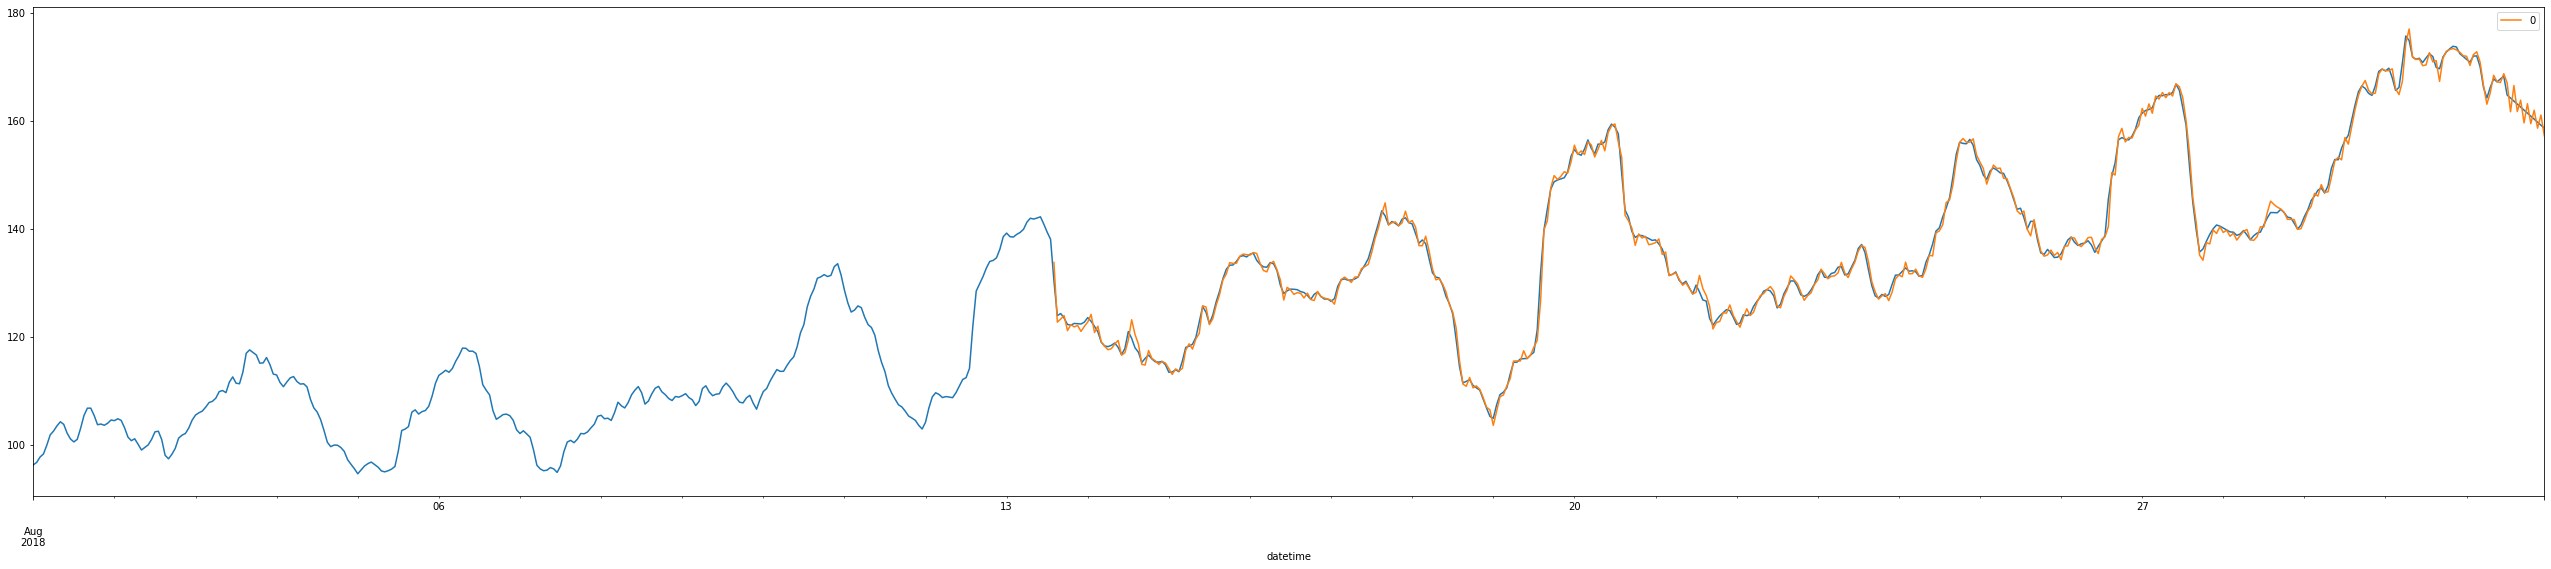

In [34]:
ax = X.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт')
pd.DataFrame(lr_preds, index=test.index).plot(figsize=(45,9), ax=ax, label='Прогноз')
None

***Вывод:*** ошибка очень низкая. Прогоз очень точно совпадает с исходным временным рядом.

#### Сезонность

In [35]:
ts_seasonal

,num_orders
datetime,
2018-03-01 00:00:00,60.248112
2018-03-01 01:00:00,20.177074
2018-03-01 02:00:00,28.982743
2018-03-01 03:00:00,17.885407
2018-03-01 04:00:00,2.791145
...,...
2018-08-31 19:00:00,-7.124270
2018-08-31 20:00:00,-2.696560
2018-08-31 21:00:00,10.670243


In [36]:
fourier = CalendarFourier(freq="H", order=2)
dp = DeterministicProcess(
    index=ts_seasonal.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X_test = X[-len(X)//10:]
X_train = X[:-len(X_test)]
y_test = ts_seasonal[-len(ts_seasonal)//10:]
y_train = ts_seasonal[:-len(y_test)]

In [37]:
seas_model = LinearRegression()
seas_model.fit(X_train, y_train)
seas_preds = seas_model.predict(X_test)
seas_rmse = mean_squared_error(y_test, seas_preds, squared=False)
print(len(seas_preds))
print('RMSE LGBM с оптимальными параметрами', round(seas_rmse, 2))

442
RMSE LGBM с оптимальными параметрами 0.0


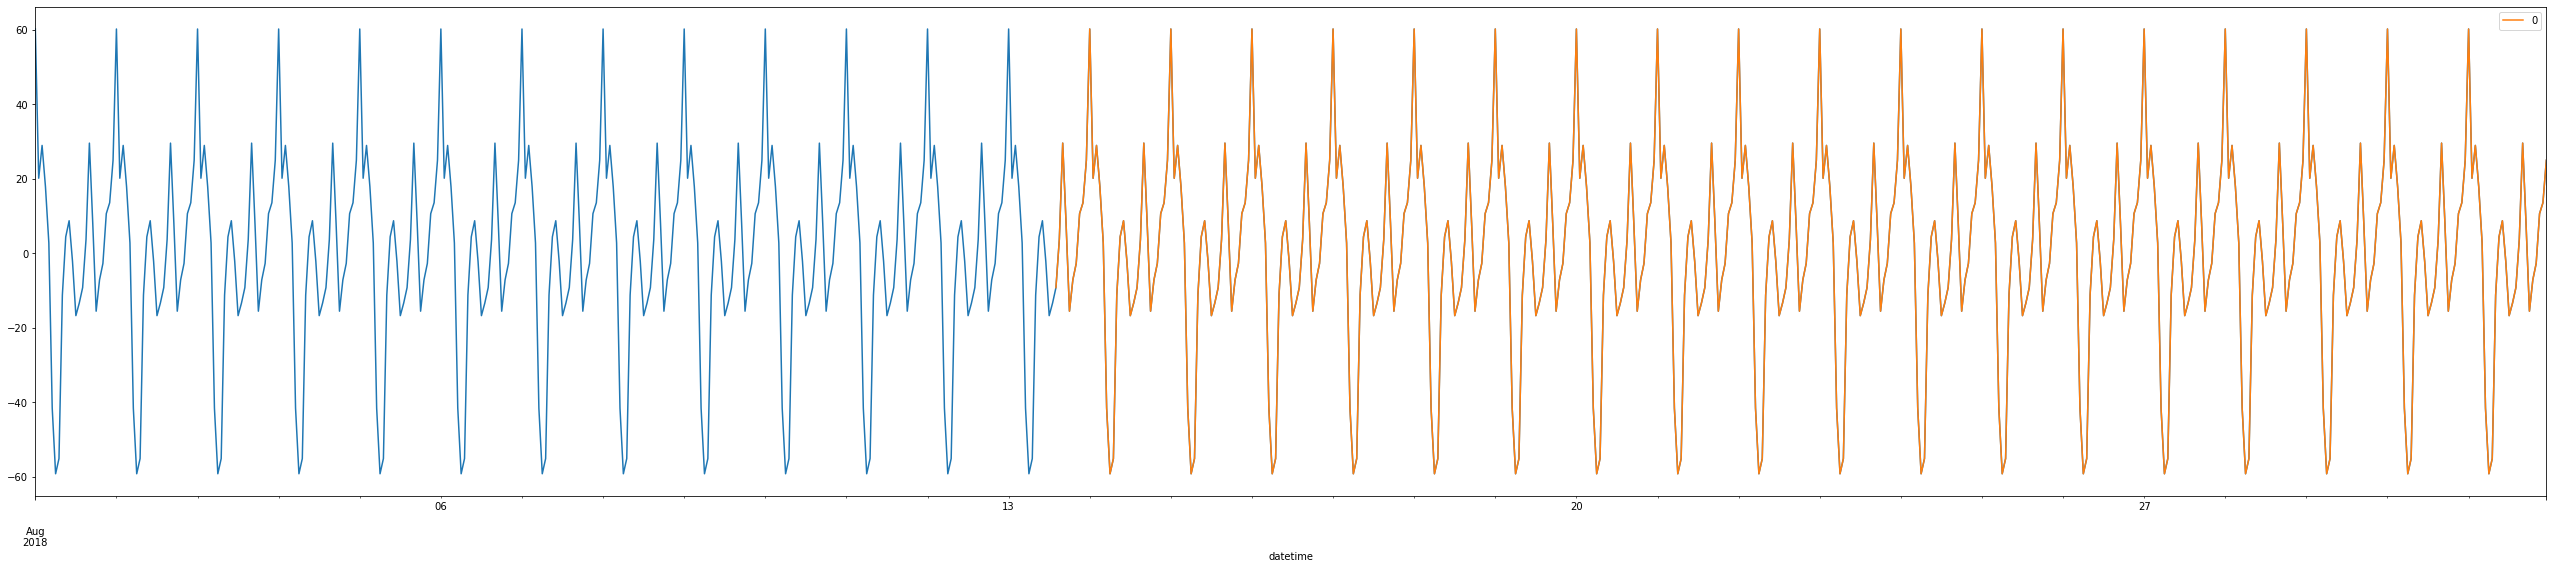

In [38]:
ax = ts_seasonal.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт')
pd.DataFrame(seas_preds, index=ts_seasonal.index[-len(seas_preds):]).plot(figsize=(45,9), ax=ax, label='Прогноз')
None

***Ввыод:*** Параметры рядов Фурье подобраны случайно. Можно было строить периодиограмму или подбирать в цикле с фиксацией наименьшей ошибки, но даже со случайными параметрами прогноз сезонной компоненты идеальный (в условиях учебной задачи усложнение модели представляется избыточным).

#### Остатки

In [39]:
def fit_resid(ts_resid):
    best_resid_rmse = 100
    for max_lag in tqdm(range(1, 30)):
        for window in range(1, 30):
            df_wlags = make_features(ts_resid.copy(), max_lag, window)
            lgbm = lightgbm.LGBMRegressor()
            lgbm_rmse_train, lgbm_rmse_test = get_lag_scores(lgbm, df_wlags)
            if lgbm_rmse_test < best_resid_rmse:
                best_resid_rmse = lgbm_rmse_test
                best_resid_lag = max_lag
                best_resid_window = window
    return best_resid_rmse, best_resid_lag, best_resid_window

In [40]:
best_resid_rmse, best_resid_lag, best_resid_window = fit_trend(ts_resid)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.04s/it]


In [41]:
best_resid_rmse, best_resid_lag, best_resid_window

(36.56420839871462, 22, 24)

In [42]:
X = make_features(ts_resid.copy(), best_resid_lag, best_resid_window)
test = X[-len(X)//10:]
train = X[:-len(test)]
train = train.dropna()

lgbm = lightgbm.LGBMRegressor()
lgbm.fit(train.drop(columns='num_orders'), train['num_orders'])
lgbm_preds = lgbm.predict(test.dropna().drop(columns='num_orders'))
lgbm_rmse = mean_squared_error(test['num_orders'].dropna(), lgbm_preds, squared=False)
print(len(lgbm_preds))
print('RMSE LGBM с оптимальными параметрами', round(lgbm_rmse, 2))

430
RMSE LGBM с оптимальными параметрами 36.68


Остатки должны быть случайными, поэтому ошибка достаточно большая даже с градиентным бустингом. Функция seasonal_decompose библиотеки statsmodel осталяет пустые значения в конце ряда с остатками. Заполним эти пустые значения прогнозами обученной модели.

In [43]:
lgbm_preds2 = lgbm.predict(test.drop(columns='num_orders').fillna(0)[-12:])
lgbm_preds = np.concatenate([lgbm_preds, lgbm_preds2])

In [44]:
print(len(lgbm_preds))

442


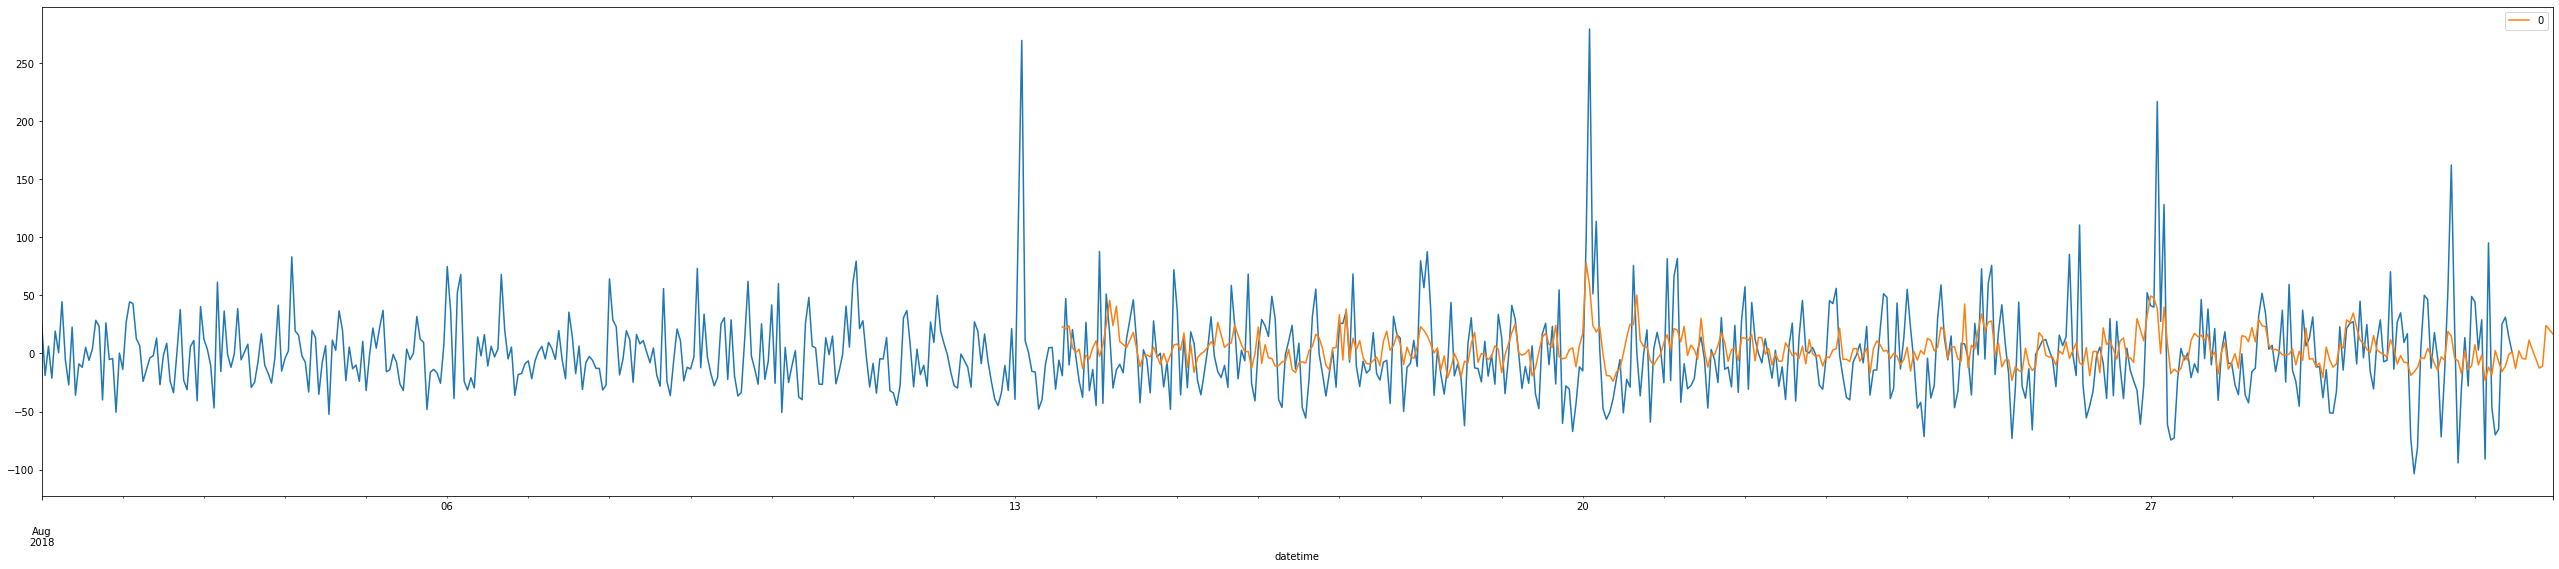

In [45]:
ax = X.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт')
pd.DataFrame(lgbm_preds, index=test.index).plot(figsize=(45,9), ax=ax, label='Прогноз')
None

Получим финальный прогноз из трех составляющих временного ряда.

In [46]:
hyb_preds = lr_preds + seas_preds.ravel() + lgbm_preds

In [47]:
mean_squared_error(df['num_orders'][-442:], hyb_preds, squared=False)

36.48353341518654

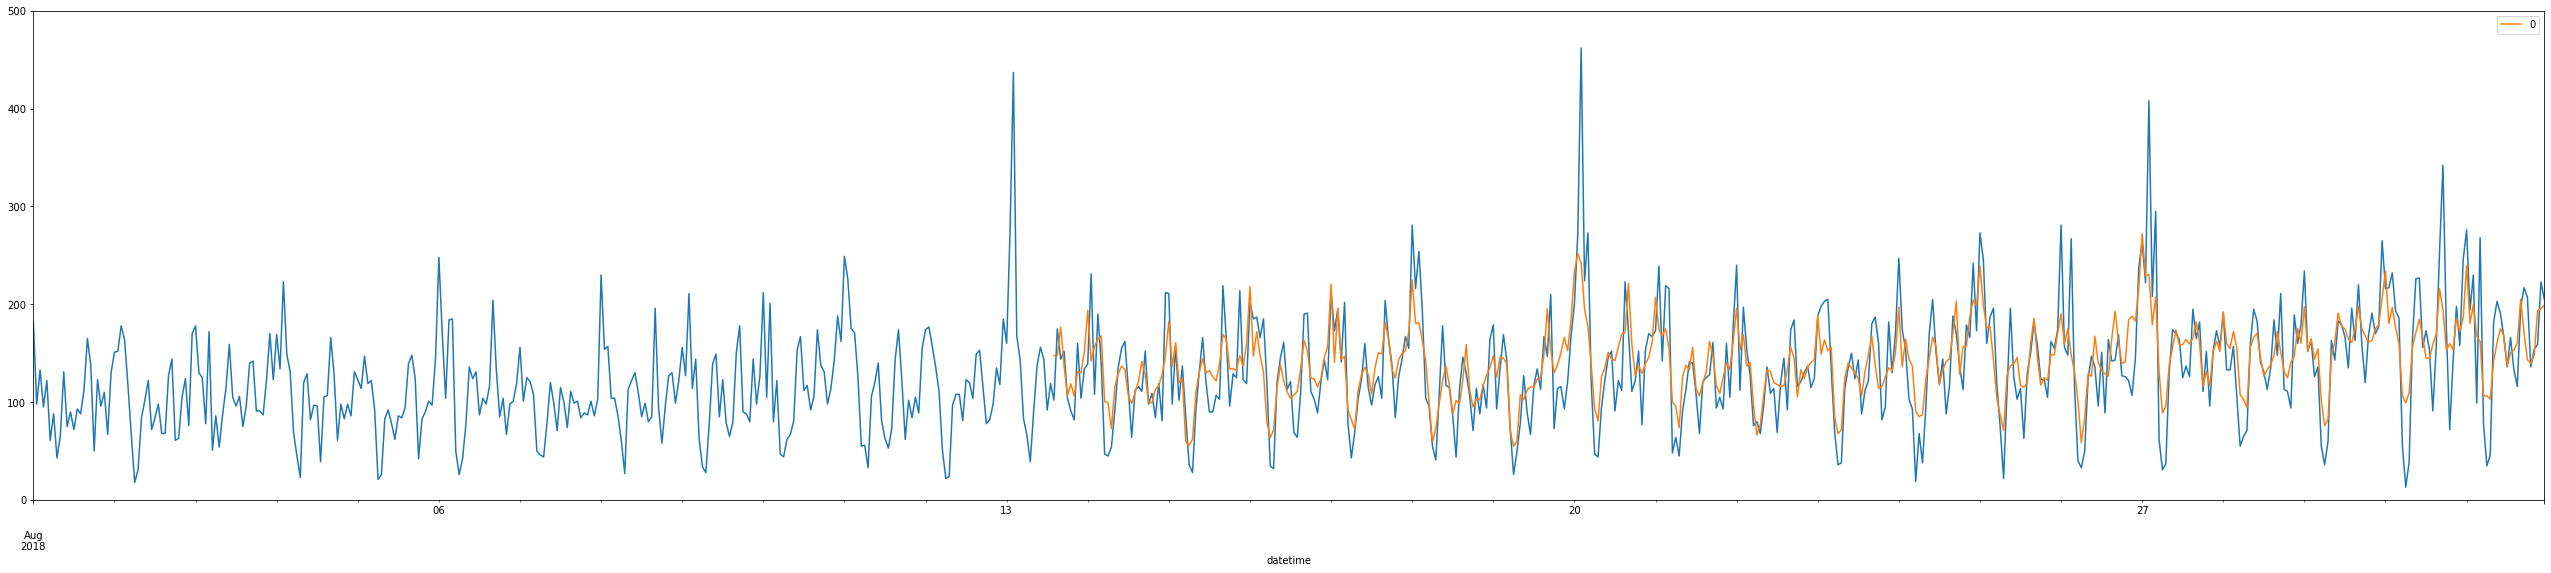

In [48]:
ax = df.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт')
pd.DataFrame(hyb_preds, index=df.index[-len(hyb_preds):]).plot(figsize=(45,9), ax=ax, label='Прогноз', ylim=(0,500))
None

***Вывод:*** Уровень ошибки собственной модели ниже, чем у линейной регрессии и градиентного бустинга - отличный результат, по моему мнению :о)))

Создадим класс модели по алгоритму выше для удобного использования на следующем этапе тестирования.

In [49]:
class HybridTSModel(object):
    def __init__(self):
        self._not_fitted = True # Флаг, который показывает, обучена ли модель

    def fit(self, ts):
        self.ts = ts
        ts_decomposed = seasonal_decompose(self.ts, extrapolate_trend=12)
        self.ts_trend = pd.DataFrame(ts_decomposed.trend, index=df.index).rename(columns={'trend':'num_orders'})
        self.ts_seasonal = pd.DataFrame(decomposed.seasonal, index=df.index).rename(columns={'seasonal':'num_orders'}) 
        self.ts_resid = pd.DataFrame(decomposed.resid, index=df.index).rename(columns={'resid':'num_orders'}) 

        print('Обучение модели тренда')
        self.best_trend_rmse, self.best_trend_lag, self.best_trend_window = self._fit_trend()
        print('Обучение модели сезонности')
        self._fit_seas()
        print('Обучение модели остатков')
        self.best_resid_rmse, self.best_resid_lag, self.best_resid_window = self._fit_resid()

    def predict(self):
        self.preds = self._predict_trend() + self._predict_seas().ravel() + self._predict_resid()
        return self.preds

    def get_score(self):
        return (mean_squared_error(self.ts['num_orders'][-442:], self.preds, squared=False))

    def plot_ts_components(self, plot_forcast=False):
        ax_trend = self.ts_trend.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт', title='Тренд')
        if plot_forcast:
            pd.DataFrame(self.trend_preds, index=self.ts_trend.index[-442:]).plot(figsize=(45,9), ax=ax_trend, label='Прогноз')
        plt.show()
        ax_seas = self.ts_seasonal.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт', title='Сезонность')
        if plot_forcast:
            pd.DataFrame(self.seas_preds, index=self.ts_seasonal.index[-442:]).plot(figsize=(45,9), ax=ax_seas, label='Прогноз')
        plt.show()
        ax_resid = self.ts_resid.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт', title='Остатки')
        if plot_forcast:
            pd.DataFrame(self.resid_preds, index=self.ts_resid.index[-442:]).plot(figsize=(45,9), ax=ax_resid, label='Прогноз')
        plt.show()

    def plot_ts_forecast(self):
        ax = self.ts.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт', title='Прогноз')
        pd.DataFrame(self.preds, index=self.ts.index[-442:]).plot(figsize=(45,9), ax=ax, label='Прогноз')
      
    def _fit_trend(self):
        self.best_trend_rmse = 100
        for max_lag in tqdm(range(1, 30)):
            for window in range(1, 30):
                df_wlags = self._make_features(self.ts_trend.copy(), max_lag, window)
                model_trend = LinearRegression()
                trend_rmse_train, trend_rmse_test = self._get_lag_scores(model_trend, df_wlags)
                if trend_rmse_test < self.best_trend_rmse:
                    self.best_trend_rmse = trend_rmse_test
                    self.best_trend_lag = max_lag
                    self.best_trend_window = window
        return self.best_trend_rmse, self.best_trend_lag, self.best_trend_window

    def _fit_seas(self):
        fourier = CalendarFourier(freq="H", order=2)
        dp = DeterministicProcess(
                index = self.ts_seasonal.index,
                constant = True,
                order = 1,
                seasonal = True,
                additional_terms = [fourier],
                drop = True,
                )
        X = dp.in_sample()
        self.X_test = X[-len(X)//10:]
        X_train = X[:-len(self.X_test)]
        self.y_test = self.ts_seasonal[-len(self.ts_seasonal)//10:]
        y_train = self.ts_seasonal[:-len(self.y_test)]
        self.seas_model = LinearRegression()
        self.seas_model.fit(X_train, y_train)

    def _fit_resid(self):
        self.best_resid_rmse = 100
        for max_lag in tqdm(range(1, 30)):
            for window in range(1, 30):
                df_wlags = self._make_features(self.ts_resid.copy(), max_lag, window)
                model_resid = lightgbm.LGBMRegressor()
                resid_rmse_train, resid_rmse_test = self._get_lag_scores(model_resid, df_wlags)
                if resid_rmse_test < self.best_resid_rmse:
                    self.best_resid_rmse = resid_rmse_test
                    self.best_resid_lag = max_lag
                    self.best_resid_window = window
        return self.best_resid_rmse, self.best_resid_lag, self.best_resid_window

    def _predict_trend(self):
        ts_predict_trend = self._make_features(self.ts_trend.copy(), self.best_trend_lag, self.best_trend_window)
        test = ts_predict_trend[-len(ts_predict_trend)//10:]
        train = ts_predict_trend[:-len(test)]
        train = train.dropna()
        model_predict_trend = LinearRegression()
        model_predict_trend.fit(train.drop(columns='num_orders'), train['num_orders'])
        self.trend_preds = model_predict_trend.predict(test.dropna().drop(columns='num_orders'))
        trend_rmse = mean_squared_error(test['num_orders'].dropna(), self.trend_preds, squared=False)
        print(len(self.trend_preds))
        print('RMSE тренда с оптимальными параметрами', round(trend_rmse, 2))
        return self.trend_preds

    def _predict_seas(self):
        self.seas_preds = self.seas_model.predict(self.X_test)
        seas_rmse = mean_squared_error(self.y_test, self.seas_preds, squared=False)
        print(len(self.seas_preds))
        print('RMSE сезонности с оптимальными параметрами', round(seas_rmse, 2))
        return self.seas_preds

    def _predict_resid(self):
        ts_predict_resid = self._make_features(self.ts_resid.copy(), self.best_resid_lag, self.best_resid_window)
        test = ts_predict_resid[-len(ts_predict_resid)//10:]
        train = ts_predict_resid[:-len(test)]
        train = train.dropna()
        model_predict_resid = lightgbm.LGBMRegressor()
        model_predict_resid.fit(train.drop(columns='num_orders'), train['num_orders'])
        self.resid_preds = model_predict_resid.predict(test.dropna().drop(columns='num_orders'))
        resid_rmse = mean_squared_error(test['num_orders'].dropna(), self.resid_preds, squared=False)
        resid_preds2 = model_predict_resid.predict(test.drop(columns='num_orders').fillna(0)[-12:])
        self.resid_preds = np.concatenate([self.resid_preds, resid_preds2])
        print(len(self.resid_preds))
        print('RMSE остатков с оптимальными параметрами', round(resid_rmse, 2))
        return self.resid_preds

    def _make_features(self, df, max_lag, rolling_mean_size):
        df['hour'] = df.index.hour
        df['day'] = df.index.day
        df['dayofweek'] = df.index.dayofweek
        for lag in range(1, max_lag + 1):
            df[f'lag_{lag}'] = df['num_orders'].shift(lag)
        df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
        return df

    def _get_lag_scores(self, model, df):
        test = df[-len(df)//10:]
        train = df[:-len(test)]
        train = train.dropna()
        test = test.dropna()
        model.fit(train.drop(columns='num_orders'), train['num_orders'])
        preds_train = model.predict(train.drop(columns='num_orders'))
        preds_test = model.predict(test.drop(columns='num_orders'))
        rmse_train = mean_squared_error(train['num_orders'], preds_train, squared=False)
        rmse_test = mean_squared_error(test['num_orders'], preds_test, squared=False)
        return rmse_train, rmse_test

## Тестирование

### Линейная модель

In [50]:
X = make_features(df.copy(), 22, 24)
test = X[-len(X)//10:]
train = X[:-len(test)]
train = train.dropna()

lr = LinearRegression()
lr.fit(train.drop(columns='num_orders'), train['num_orders'])
lr_preds = lr.predict(test.drop(columns='num_orders'))
lr_rmse = mean_squared_error(test['num_orders'], lr_preds, squared=False)
print('RMSE линейной регрессии с оптимальными параметрами', round(lr_rmse, 2))

RMSE линейной регрессии с оптимальными параметрами 43.93


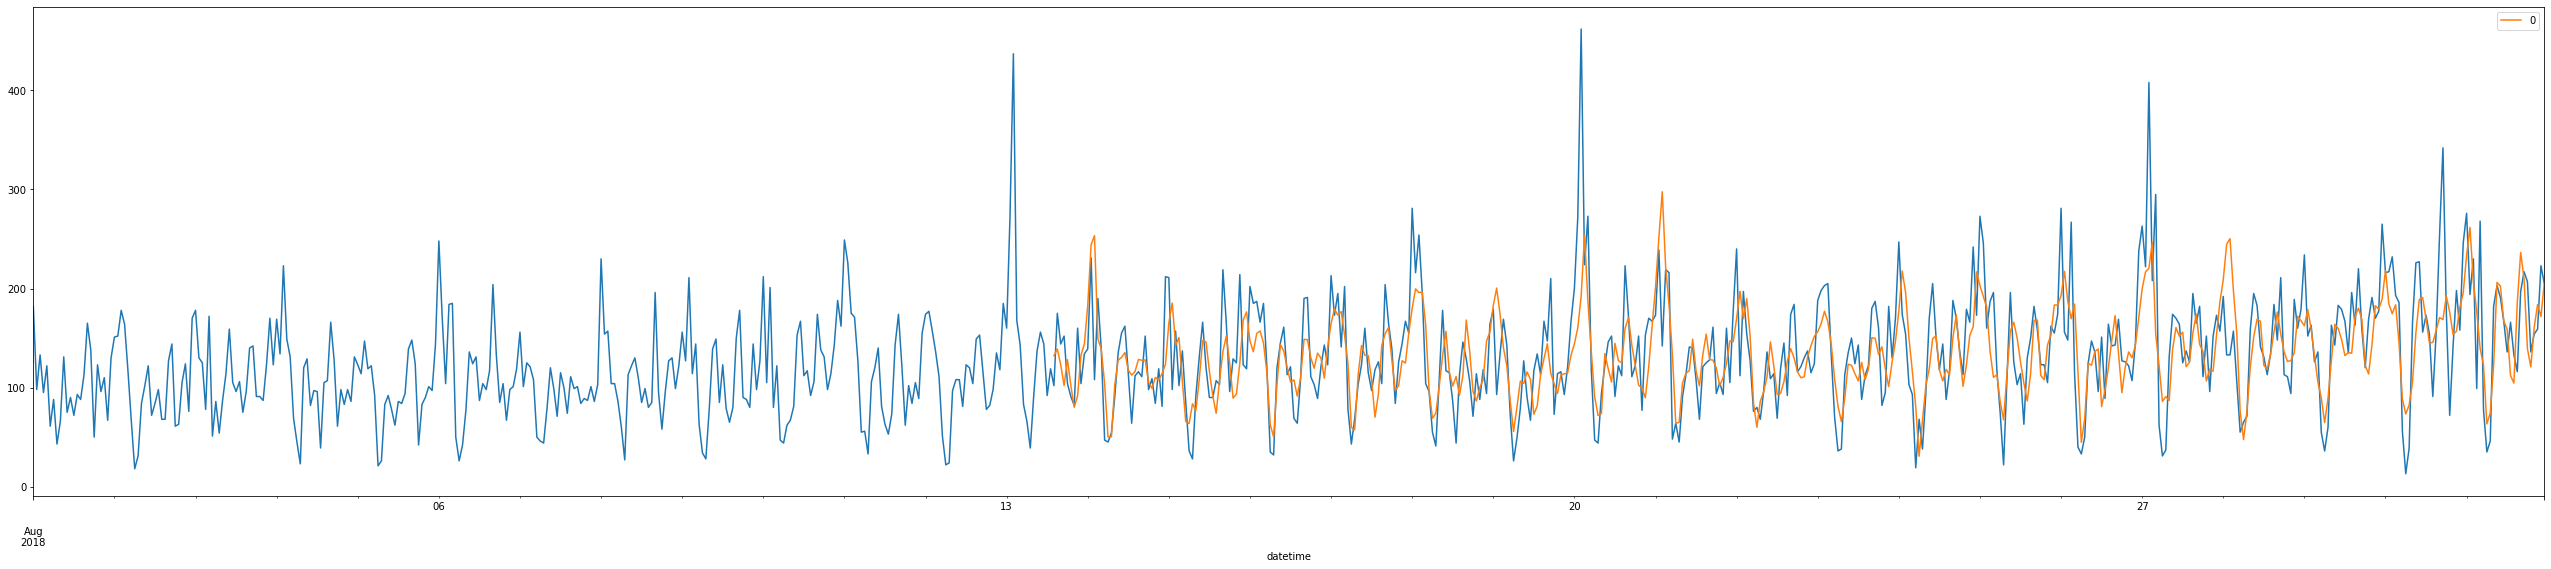

In [51]:
ax = X.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт')
pd.DataFrame(lr_preds, index=test.index).plot(figsize=(45,9), ax=ax, label='Прогноз')
None

### Градиентный бустинг

In [52]:
X = make_features(df.copy(), 25, 19)
test = X[-len(X)//10:]
train = X[:-len(test)]
train = train.dropna()

lgbm = lightgbm.LGBMRegressor()
lgbm.fit(train.drop(columns='num_orders'), train['num_orders'])
lgbm_preds = lgbm.predict(test.drop(columns='num_orders'))
lgbm_rmse = mean_squared_error(test['num_orders'], lgbm_preds, squared=False)
print('RMSE градиентного бустинга с оптимальными параметрами', round(lgbm_rmse,2))

RMSE градиентного бустинга с оптимальными параметрами 39.3


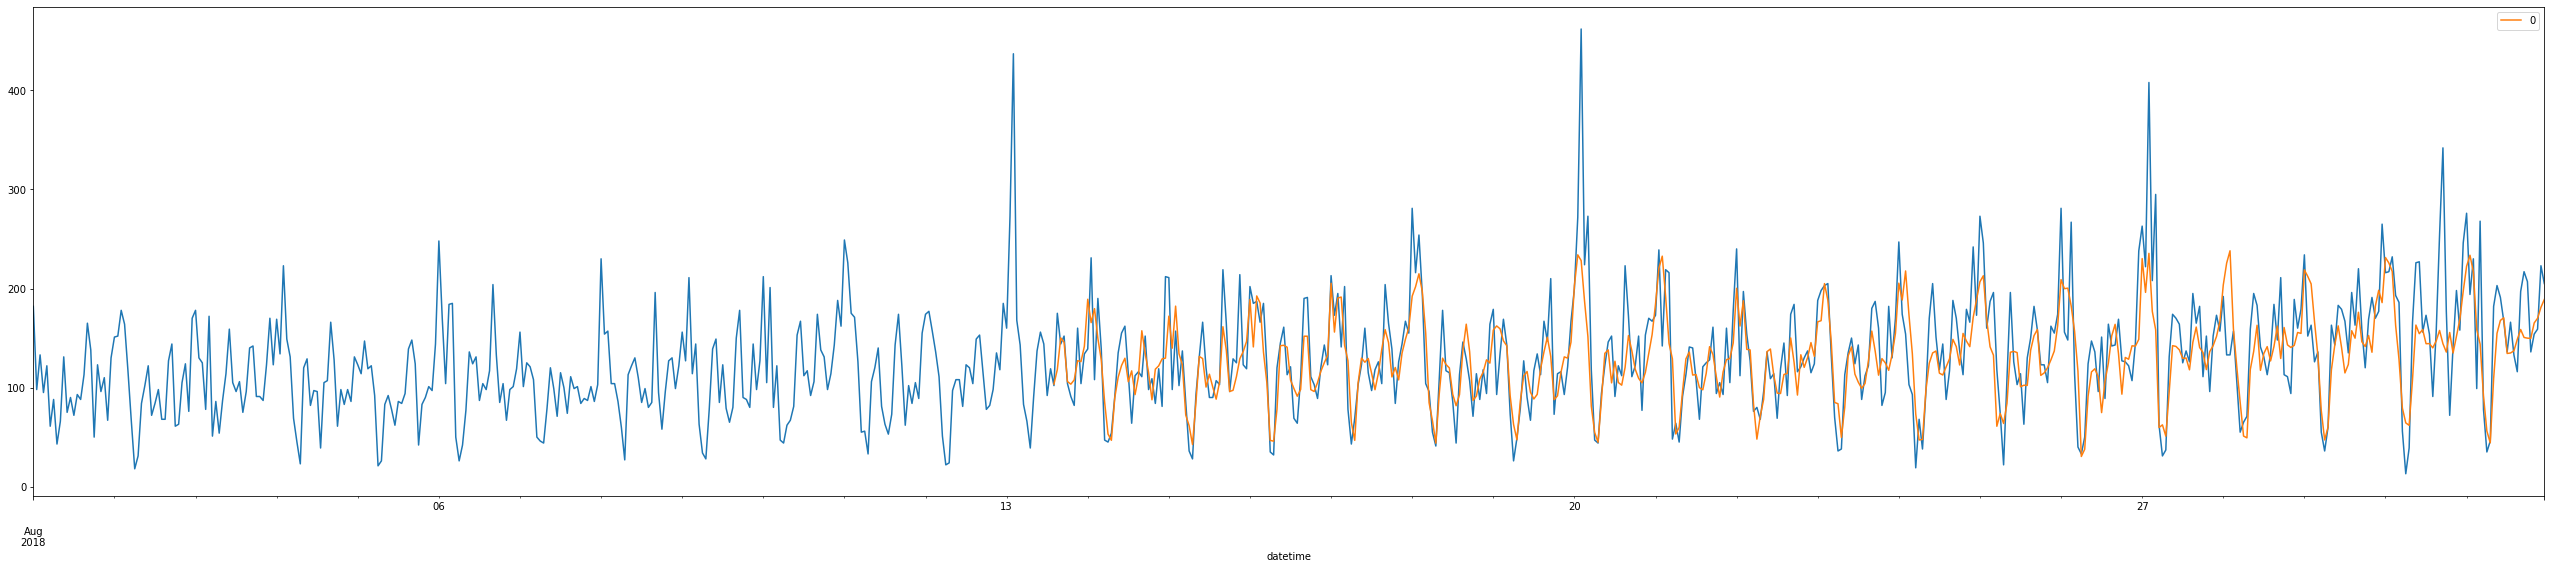

In [53]:
ax = X.loc['2018-08-01':,'num_orders'].plot(figsize=(45,9), label='Факт')
pd.DataFrame(lgbm_preds, index=test.index).plot(figsize=(45,9), ax=ax, label='Прогноз')
None

### Гибридная модель

In [54]:
hybrid_model = HybridTSModel()
hybrid_model.fit(df.copy())

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

Обучение модели тренда


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

Обучение модели сезонности
Обучение модели остатков


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [02:20<00:00,  4.86s/it]


In [55]:
preds = hybrid_model.predict()

442
RMSE тренда с оптимальными параметрами 1.03
442
RMSE сезонности с оптимальными параметрами 0.0
442
RMSE остатков с оптимальными параметрами 35.65


In [56]:
print('RMSE гибридной модели:',round(hybrid_model.get_score(),2))

RMSE гибридной модели: 35.52


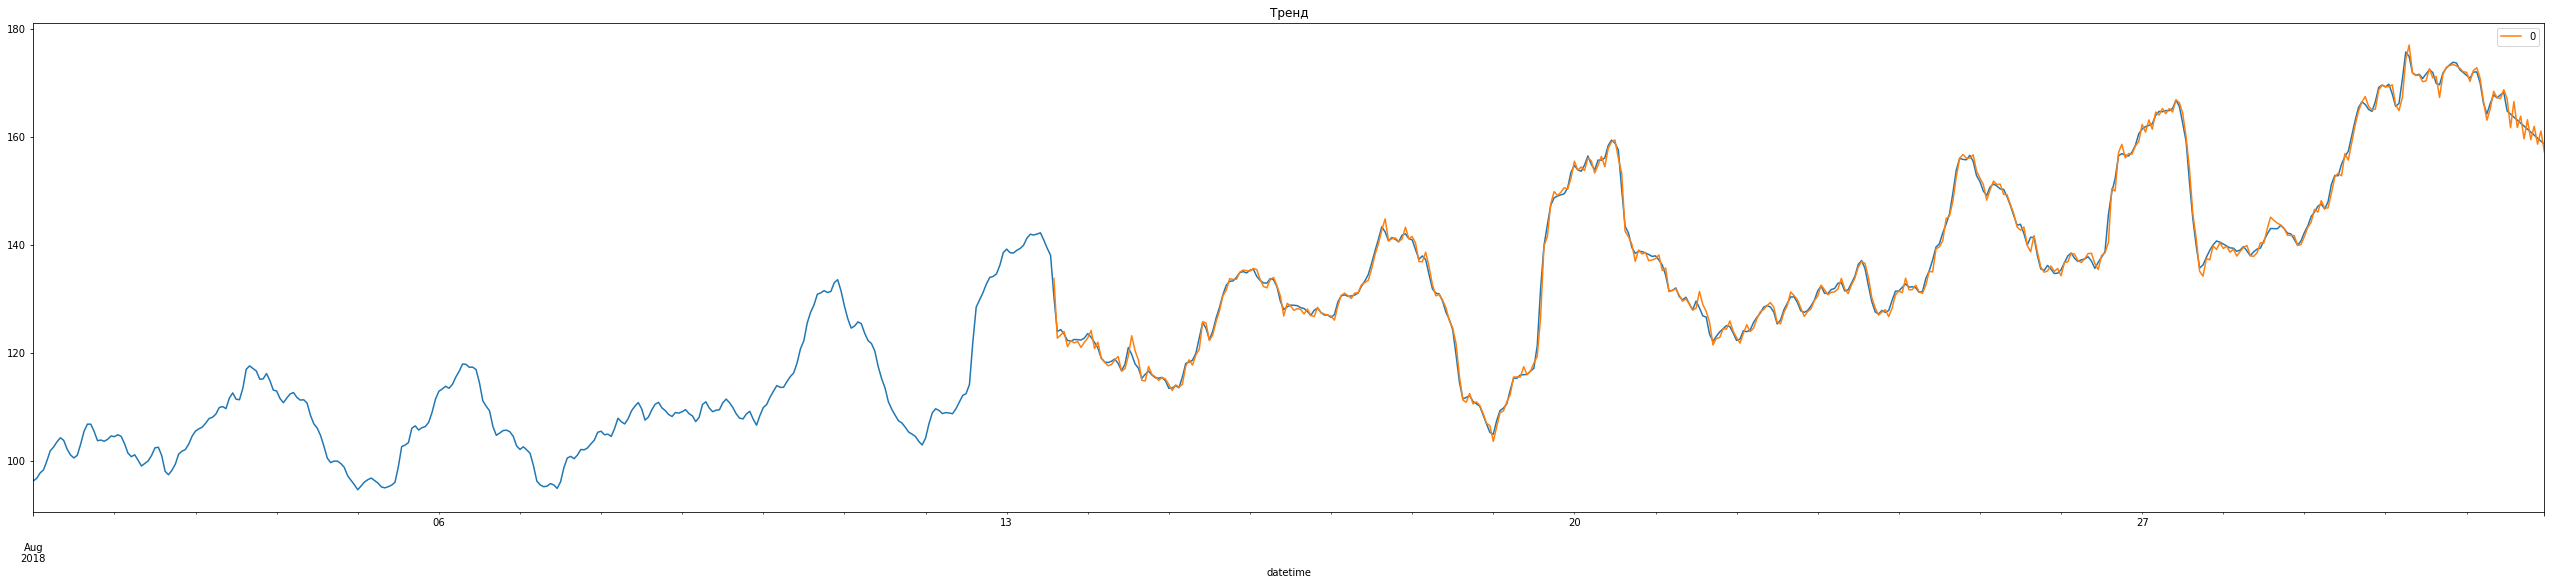

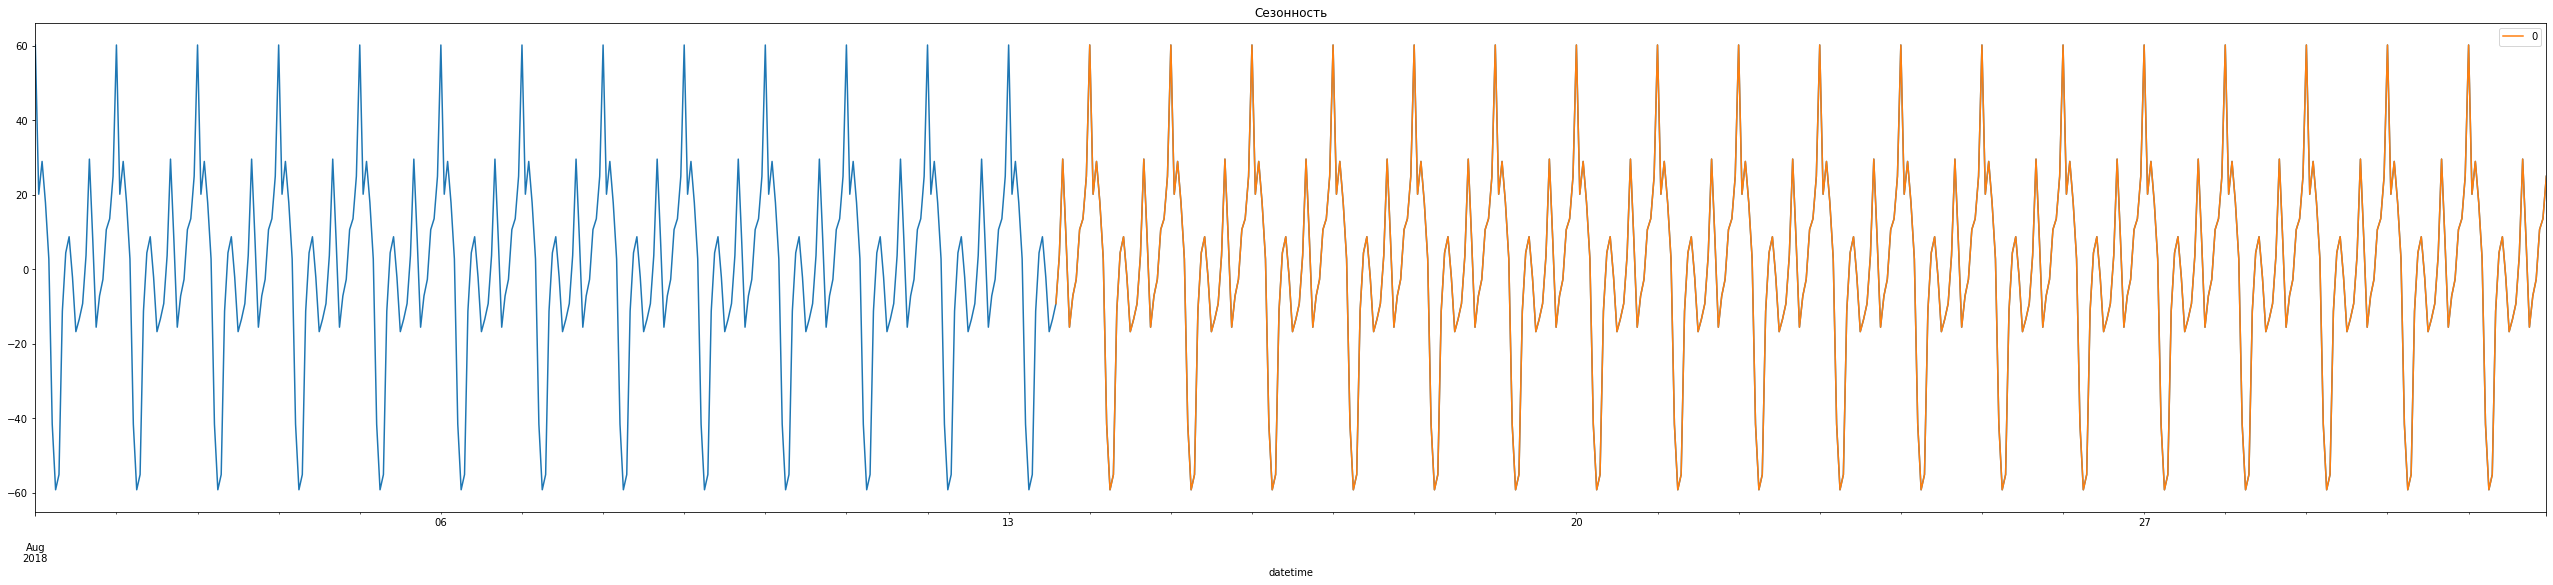

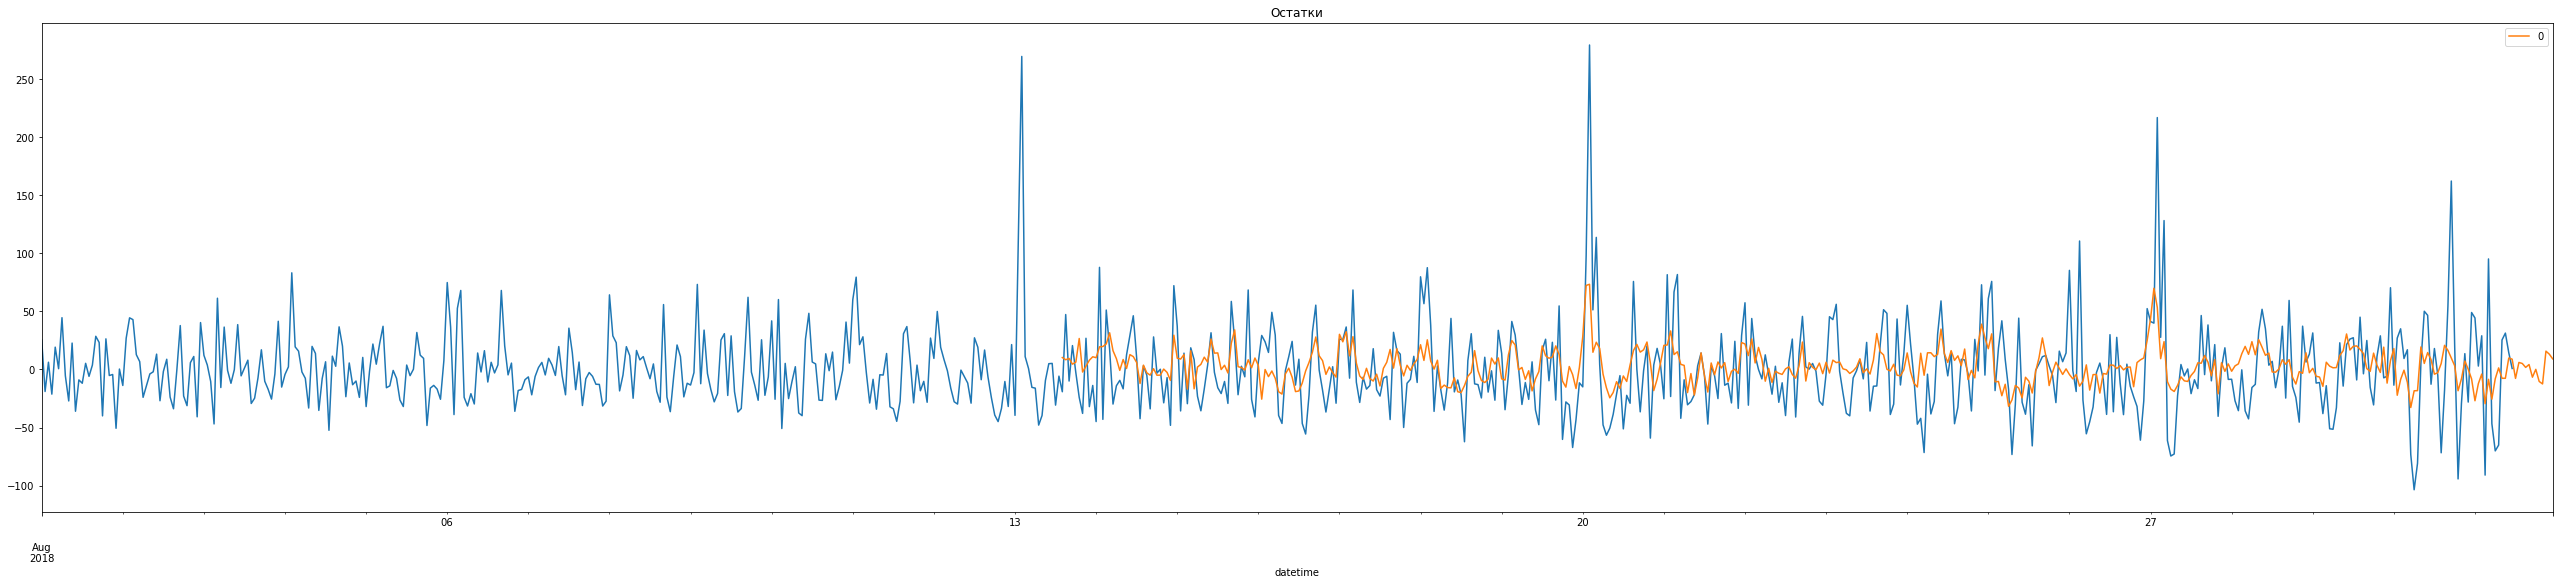

In [57]:
hybrid_model.plot_ts_components(plot_forcast=True)

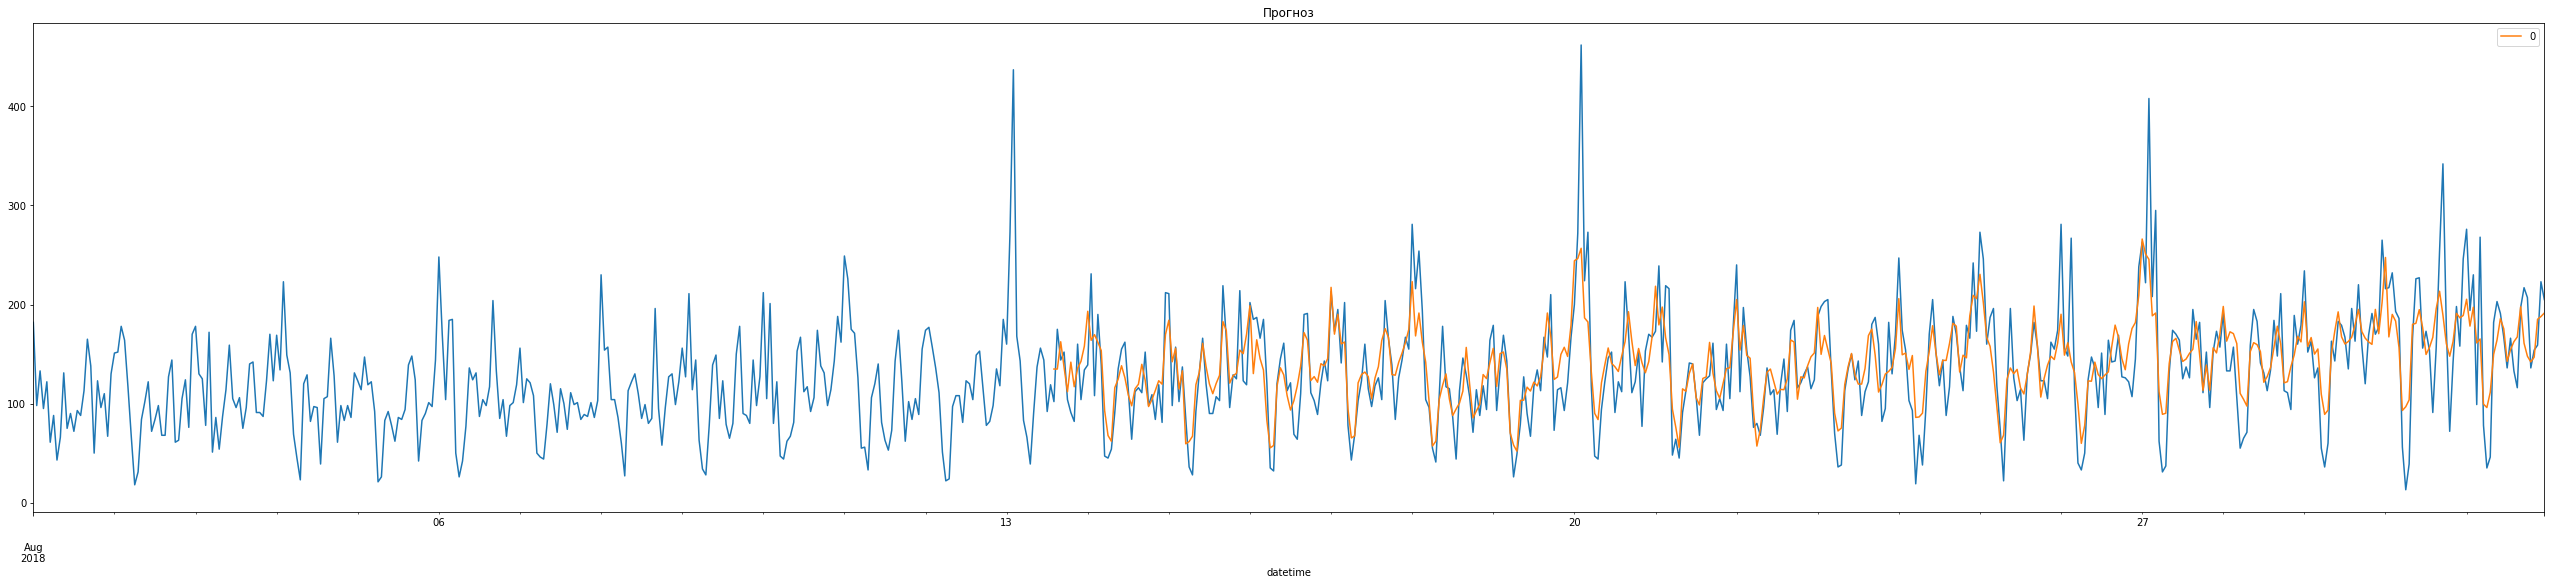

In [58]:
hybrid_model.plot_ts_forecast()

***Вывод:*** модель еще можно улучшать, конечно же (добавление возможности прогнозирования более чем на один шаг, обработка входных данных, проверка модели на обученность перед выводом прогнозов и т.п.), но нужно срочно переходить к следующему спринту по текстовым данным. RMSE ниже 48, так что в принципе норм :о)))

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48